In [76]:
from fmp_python.fmp import FMP
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

import statsmodels as sm

load_dotenv()
FMP_API_KEY = os.getenv("FMP_API_KEY")
fmp = FMP(output_format='pandas',api_key=FMP_API_KEY)

# Week 1 - Return Types, Setup, and Data Foundations


In [67]:
#Access & Download financial data
microsoftData = fmp.get_historical_price("MSFT")

#Overview of Data
microsoftData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1256 non-null   object 
 1   open              1256 non-null   float64
 2   high              1256 non-null   float64
 3   low               1256 non-null   float64
 4   close             1256 non-null   float64
 5   adjClose          1256 non-null   float64
 6   volume            1256 non-null   int64  
 7   unadjustedVolume  1256 non-null   int64  
 8   change            1256 non-null   float64
 9   changePercent     1256 non-null   float64
 10  vwap              1256 non-null   float64
 11  label             1256 non-null   object 
 12  changeOverTime    1256 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 127.7+ KB


### Interesting Notes Include:
- date is an object, appears to be a string in the form: yyyy-mm-dd
- volume and unadjustedVolume are int64 (only integer # of sales)
- label is an object, appears to be a string in the form: month dd, yy
- dataFrame is has latest date at top, I'd like past first
- I also cannot map the 'change' column 

I think the date should be the index (currently none) and it should be a proper datetime

In [68]:
microsoftData['date'] = pd.to_datetime(microsoftData['date'],yearfirst=True) #Fixes the datetime issue
microsoftData = microsoftData.set_index('date') # Sets the new datetime to be the key
microsoftData = microsoftData.sort_index()


In [69]:
#Now if we look at .head() [the first 5 rows] is the key and the top if the oldest record (2020-06-22)
microsoftData.head()

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2020-06-22,195.79,200.76,195.23,200.57,192.16,32818929,32818929,4.78,2.440000,198.0875,"June 22, 20",0.024400
2020-06-23,202.09,203.95,201.43,201.91,193.45,30917447,30917447,-0.18,-0.089069,202.3450,"June 23, 20",-0.000891
2020-06-24,201.60,203.25,196.56,197.84,189.55,36740647,36740647,-3.76,-1.870000,199.8125,"June 24, 20",-0.018700
2020-06-25,197.80,200.61,195.47,200.34,191.94,27803933,27803933,2.54,1.280000,198.5550,"June 25, 20",0.012800
2020-06-26,199.73,199.89,194.88,196.33,188.10,54675800,54675800,-3.40,-1.700000,197.7075,"June 26, 20",-0.017000


### Simple Plots

- line plots (time series): high, low, close, adjClose

<Axes: xlabel='date'>

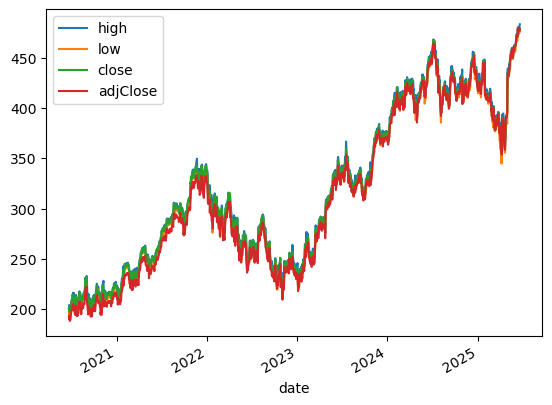

In [70]:
microsoftData[['high','low','close','adjClose']].plot() # quite messy, may be nice to one a year

<Axes: xlabel='date'>

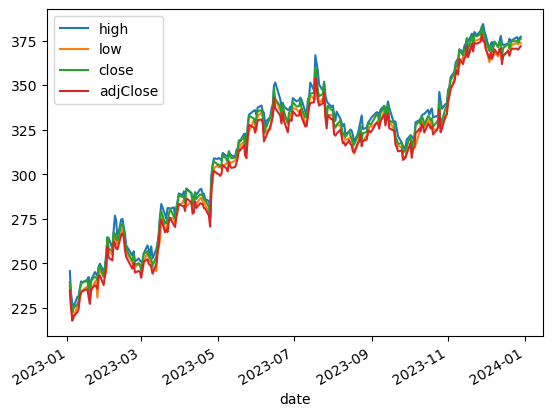

In [71]:
microsoftData_2023 = microsoftData.iloc[microsoftData.index.year == 2023]
microsoftData_2023[['high','low','close','adjClose']].plot()

### Simple Calculations
- simple return (.pct_change)
- log return

In [72]:
microsoftData['simple_return'] = microsoftData['close'].pct_change()
microsoftData['log_return'] = np.log(microsoftData['close'] / microsoftData['close'].shift(1))

<Axes: ylabel='Frequency'>

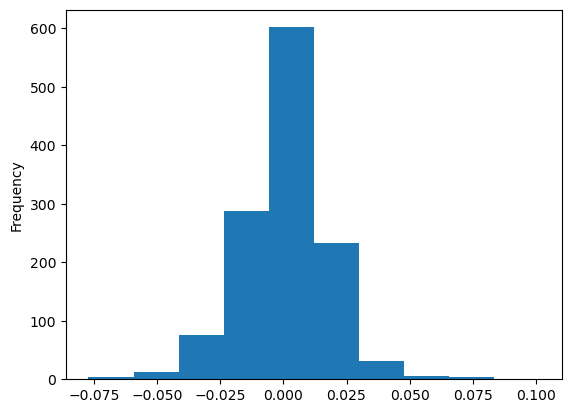

In [73]:
microsoftData['simple_return'].plot(kind='hist')

In [74]:
simple_skew = microsoftData['simple_return'].skew()
simple_kurtosis = microsoftData['simple_return'].kurtosis()

log_skew = microsoftData['log_return'].skew()
log_kurtosis = microsoftData['log_return'].kurtosis()

print(f"The simple returns have a skew={simple_skew} and kurtosis={simple_kurtosis}")
print(f"The log returns have a skew={log_skew} and kurtosis={log_kurtosis}")

The simple returns have a skew=0.12972171818899886 and kurtosis=2.7896957304224888
The log returns have a skew=0.011017914170098867 and kurtosis=2.6207012131086875


Interestingly both have a slight positive skew. Initially I beleieved the kurtosis was sub-normal (kurt=3 for the normal), but pandas documents set kurtosis of normal to 0 so this is a higher kurtosis (lepto - fat tailed)

### Confirming the Skew
A qqplot can be used to identify deviations from the normal, because both returns are small, we just plot simple

We see the right side (positive skew) deviates more compared to the left side (netaive skew)

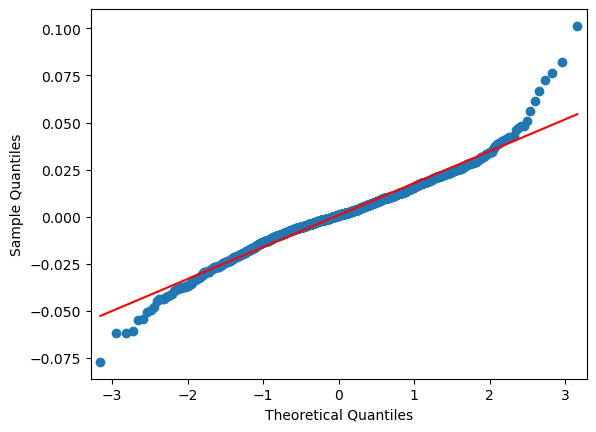

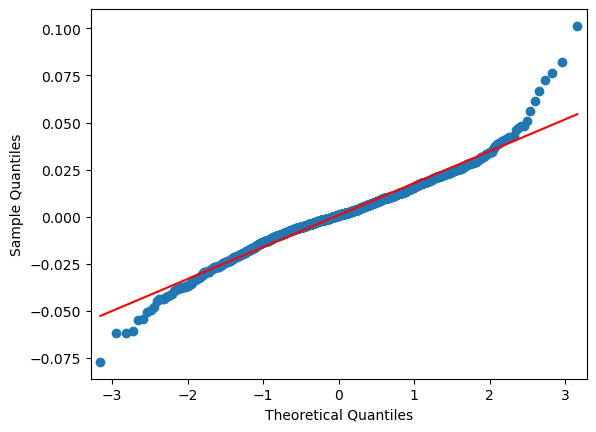

In [77]:
simple_return_array = microsoftData['simple_return'].dropna().to_numpy()
sm.api.qqplot(simple_return_array,line='s',loc=simple_return_array.mean())


### Cumulative Returns

The log returns are additive whereas the simple return can be found using a cumulative sum

In [78]:
microsoftData['cumulative_return'] = (microsoftData['simple_return'] + 1).cumprod() - 1

In [ ]:
# Some modular functions based on the analysis from Week 1

def grab_ticker(api_key_val, ticker):
    fmp = FMP(output_format='pandas',api_key=api_key_val)
    raw_data = fmp.get_historical_price(ticker)
    raw_data['date'] = pd.to_datetime(raw_data['date'],yearfirst=True)
    raw_data = raw_data.set_index('date')
    raw_data = raw_data.sort_index()
    return raw_data

def single_year_data(df, year):
    return df.iloc[df.index.year == year]

def returns_df(df):
    return pd.DataFrame(
        data={
            'simple_returns':df['close'].pct_change(),
            "log_returns":np.log(df['close']/df['close'].shift(1))
            } ,index=df.index)
    

# Week 2 - Distributions + Cumulative Returns + Intro to Bonds